[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
3178/3178 [==============================] - 23s 6ms/step - loss: 0.0025 - val_loss: 8.8579e-04
Epoch 2/10
3178/3178 [==============================] - 21s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/10
3178/3178 [==============================] - 20s 6ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/10
3178/3178 [==============================] - 20s 6ms/step - loss: 0.0010 - val_loss: 2.6357e-04
Epoch 5/10
3178/3178 [==============================] - 21s 6ms/step - loss: 9.1668e-04 - val_loss: 5.5701e-04
Epoch 6/10
3178/3178 [==============================] - 20s 6ms/step - loss: 8.4066e-04 - val_loss: 2.7903e-04
Epoch 7/10
3178/3178 [==============================] - 21s 7ms/step - loss: 8.6476e-04 - val_loss: 2.8423e-04
Epoch 8/10
3178/3178 [==============================] - 21s 7ms/step - loss: 8.0160e-04 - val_loss: 3.7908e-04
Epoch 9/10
25/25 [==============================] - 1s 4ms/step
RMS

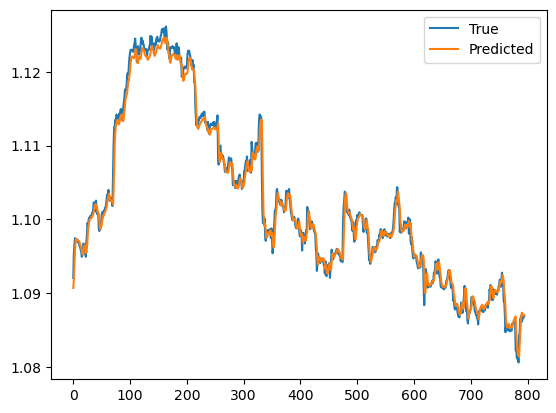

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 16ms/step
Trading Decision at 2023-09-20 11:10:00.087896: Buy


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import time

def fetch_stock_data(ticker, start, end):
    return yf.download(ticker, start=start, end=end, interval="1h")

def prepare_data(stock_data, lookback):
    features = ['Adj Close', 'Volume']
    dataset = stock_data[features].copy()  
    
    scalers = {}
    scaled_data = {} 

    for feature in features:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data[feature] = scaler.fit_transform(dataset[feature].values.reshape(-1, 1)).flatten()  
        scalers[feature] = scaler

    dataset = pd.DataFrame(scaled_data)  

    x_data, y_data = [], []

    for i in range(lookback, len(dataset)):
        x_data.append(dataset.iloc[i-lookback:i].values)
        y_data.append(dataset['Adj Close'].iloc[i])

    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], len(features)))

    return x_data, y_data, scalers

def build_lstm_model(lookback, feature_count):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, feature_count)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_next_24_hours(model, data, scalers, lookback):
    latest_data = data[-lookback:]
    scaled_prediction = model.predict(latest_data.reshape(1, lookback, 2))
    return scalers['Adj Close'].inverse_transform(scaled_prediction)

def trading_decision(predicted_value, current_value):
    return 'Buy' if predicted_value > current_value else 'Sell'

def main():
    ticker = 'EURUSD=X'
    start_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
    end_date = datetime.strptime('2023-08-24', '%Y-%m-%d')
    lookback = 24
    
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    x_data, y_data, scalers = prepare_data(stock_data, lookback)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

    model = build_lstm_model(lookback, x_data.shape[2])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(x_train, y_train, batch_size=1, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stopping])

    predictions = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"RMSE: {rmse}")

    adj_close_scaler = scalers['Adj Close']
    inversed_predictions = adj_close_scaler.inverse_transform(predictions)
    plt.plot(adj_close_scaler.inverse_transform(y_test.reshape(-1, 1)))
    plt.plot(inversed_predictions)
    plt.legend(['True', 'Predicted'])
    plt.show()

    # Continuous Prediction & Trading Logic
    while True:
        current_date = datetime.now()
        last_data_date = current_date - timedelta(hours=lookback+1)
        latest_data = fetch_stock_data(ticker, last_data_date, current_date).tail(lookback+1) 
        x_latest, _, _ = prepare_data(latest_data, lookback)
        
        next_hour_prediction = predict_next_24_hours(model, x_latest, scalers, lookback)
        current_value = latest_data['Adj Close'].iloc[-1]
        
        decision = trading_decision(next_hour_prediction, current_value)
        print(f"Trading Decision at {current_date}: {decision}")
        
        # TODO: Integrate your trading API logic here for executing trades
        
        time.sleep(3600)

if __name__ == "__main__":
    main()
